In [ ]:
from keras.models import Model
from keras.layers import Input
from ae_model import encoder_vgg16, decoder1_vgg16, decoder2_vgg16, decoder3_vgg16, encoder1_vgg16

input_shape = Input(shape=[224, 224, 3])
ae = Model(input_shape, decoder1_vgg16(encoder_vgg16(input_shape)))

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from keras.preprocessing.image import img_to_array, load_img

datasets = []
tests = []
path = './grid-search/dataset-emps/images/'
test_path = './grid-search/dataset-emps/test_data/img/'

files = os.listdir(path)
test_files = os.listdir(test_path)


for i in tqdm(files):
    img = load_img(path+i, target_size=(224, 224))
    datasets.append(img_to_array(img))

for i in tqdm(test_files):
    img = load_img(test_path+i, target_size=(224, 224))
    tests.append(img_to_array(img))

data_array = np.reshape(datasets, (len(datasets), 224, 224, 3))
data_array = data_array.astype('float32') / 255.

test_array = np.reshape(tests, (len(tests), 224, 224, 3))
test_array = test_array.astype('float32') / 255.


print(data_array.shape)
print(test_array.shape)

100%|██████████| 30/30 [00:00<00:00, 163.56it/s]


(435, 224, 224, 3)
(30, 224, 224, 3)


In [ ]:
from keras.callbacks import TensorBoard
import tensorflow as tf
from datetime import datetime

tf.random.set_seed(44)

log_dir = './grid-search/logs/dataset_emps/train_all_imgs_' + datetime.now().strftime("%Y%m%d-%H%M%S") 

r = 'adam_mse_40_100ep'

fw =  tf.summary.create_file_writer(log_dir)
with fw.as_default():
    tf.summary.text("record", r, step=0)

ae.compile(optimizer='adam', loss='mse')

rr = ae.fit(data_array, data_array, batch_size=40, epochs=100, verbose=1, validation_data=(test_array, test_array), callbacks=[TensorBoard(log_dir=log_dir)])

ae.save('./grid-search/checkpoints/emps_models')

ae.save('./grid-search/checkpoints/h5_files/emps.h5')

In [ ]:
from PIL import Image

img = cv2.imread('./grid-search/dataset-emps/images/5a25d179cc.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (244, 244)) / 255.


maps = Image.open('./grid-search/dataset-emps/segmaps/5a25d179cc.png')
maps = np.array(maps).astype('uint8')
maps[maps > 0] = 1
maps = cv2.resize(maps, (224, 224)) / 255.
maps = np.expand_dims(maps, axis= -1).astype('float32')


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].imshow(img)
ax[1].imshow(np.squeeze(maps), cmap = 'gray')

plt.show()

In [4]:
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np


path = './grid-search/dataset-emps/images/'
map_path = './grid-search/dataset-emps/segmaps/'
files = os.listdir(path)

img_data = []
map_data = []

for i in tqdm(range(len(files))):
    img = cv2.imread(path + files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224)) / 255.

    maps = Image.open(map_path + files[i])
    maps = np.array(maps).astype('uint8')
    maps[maps > 0] = 1
    maps = cv2.resize(maps, (224, 224)) / 255.
    maps = np.expand_dims(maps, axis= -1).astype('float32')

    img_data.append(img)
    map_data.append(maps)




100%|██████████| 435/435 [00:05<00:00, 77.87it/s]


In [5]:
img_data = np.array(img_data)
map_data = np.array(map_data)

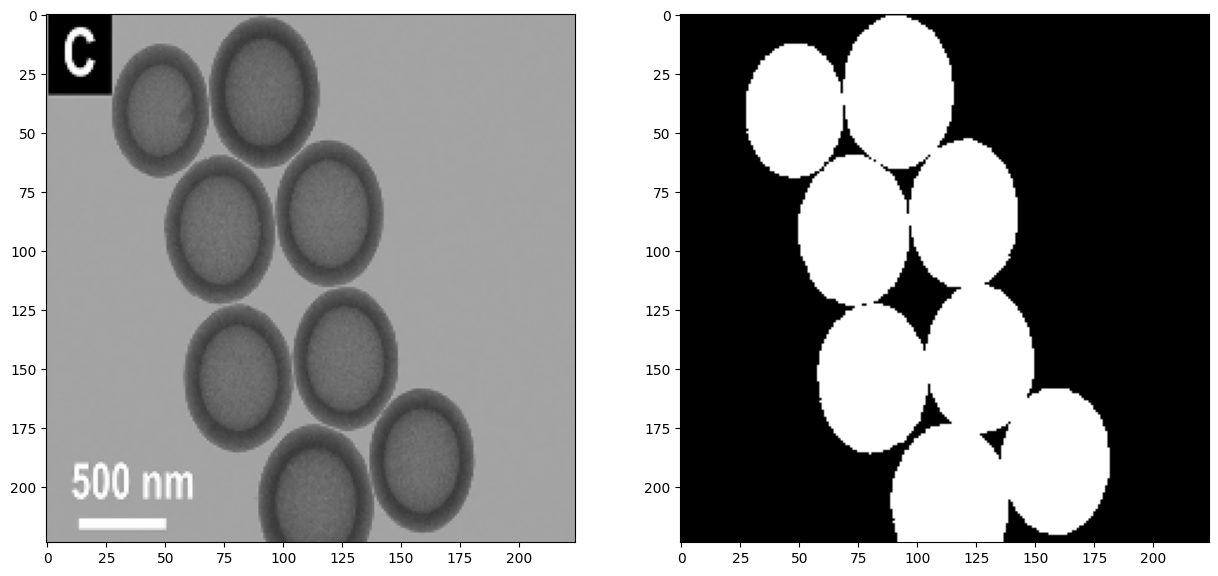

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].imshow(img_data[33])
ax[1].imshow(np.squeeze(map_data[33]), cmap = 'gray')

plt.show()

In [7]:
np.save('./grid-search/dataset-emps/npy/full_img_data.npy', img_data)
np.save('./grid-search/dataset-emps/npy/full_map_data.npy', map_data)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(img_data, map_data, test_size=0.2, random_state=44)
 

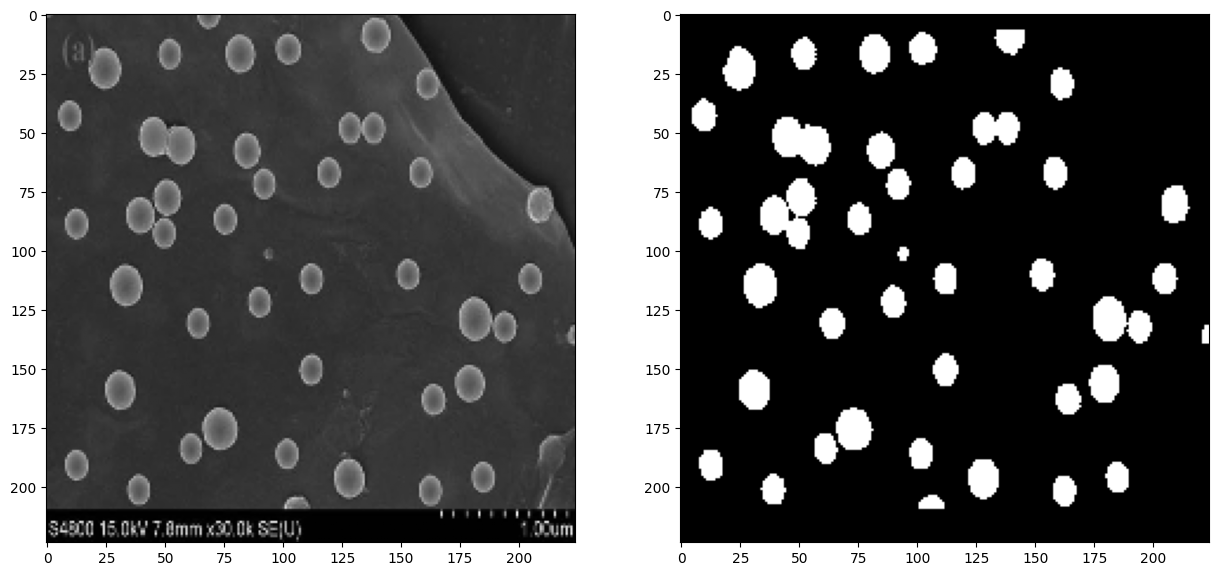

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].imshow(x_train[11])
ax[1].imshow(np.squeeze(y_train[11]), cmap = 'gray')

plt.show()

In [10]:
np.save('./grid-search/dataset-emps/npy/spilt_80train_20test/x_train.npy', x_train)
np.save('./grid-search/dataset-emps/npy/spilt_80train_20test/y_train.npy', y_train)
np.save('./grid-search/dataset-emps/npy/spilt_80train_20test/x_test.npy', x_test)
np.save('./grid-search/dataset-emps/npy/spilt_80train_20test/y_test.npy', y_test)

固定测试集  
按比例(20%-100%) 送入训练集    


In [11]:
import numpy as np

sp1 = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/x_train.npy')
sp2 = np.load('./grid-search/dataset-emps/npy/spilt_80train_20test/y_train.npy')

In [12]:
from sklearn.model_selection import train_test_split

perc = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in perc:
    x_train, x_test, y_train, y_test = train_test_split(sp1, sp2, train_size=i, random_state=44)

    name1 = './grid-search/dataset-emps/npy/spilt_80train_20test/sp/x_train_' + str(i) + '_ss.npy'
    name2 = './grid-search/dataset-emps/npy/spilt_80train_20test/sp/y_train_' + str(i) + '_ss.npy'

    print(name1)
    print(x_train.shape)
    print(name2)
    print(y_train.shape)

    np.save(name1, x_train)
    np.save(name2, y_train)

./grid-search/dataset-emps/npy/spilt_80train_20test/sp/x_train_0.1_ss.npy
(34, 224, 224, 3)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/y_train_0.1_ss.npy
(34, 224, 224, 1)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/x_train_0.2_ss.npy
(69, 224, 224, 3)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/y_train_0.2_ss.npy
(69, 224, 224, 1)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/x_train_0.3_ss.npy
(104, 224, 224, 3)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/y_train_0.3_ss.npy
(104, 224, 224, 1)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/x_train_0.4_ss.npy
(139, 224, 224, 3)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/y_train_0.4_ss.npy
(139, 224, 224, 1)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/x_train_0.5_ss.npy
(174, 224, 224, 3)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/y_train_0.5_ss.npy
(174, 224, 224, 1)
./grid-search/dataset-emps/npy/spilt_80train_20test/sp/x_train_0.6_ss.npy
